In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Classifier
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold

Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [2]:
data_params = { "n_dim": 1,
                "n_mc": 1000000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 1000000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 100000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": True,
                "data_rec_cut": True,
                "data_gen_cut": True ,
                "efficiency": 0.1,
                "acceptance": 0.1
}

In [3]:
ToyModel = GaussianToy(data_params)

Define background subtraction classifier

In [4]:
bkg_true = torch.cat([ToyModel.data_rec[ToyModel.data_rec_mask.bool()], ToyModel.mc_background_rec])
weights_true = torch.cat([torch.ones_like(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()]), torch.ones_like(ToyModel.mc_background_rec[:,0]) * -1])
bkg_false = ToyModel.data_rec[ToyModel.data_rec_mask.bool()]
weights_false = torch.ones_like(bkg_false[:,0])

In [5]:
background_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [6]:
background_classifier = Classifier(1, background_classifier_params)

In [7]:
background_classifier.train_classifier(bkg_true, bkg_false, weights_true, weights_false)

Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.249468207359314 after time 17.1
    Finished epoch 6 with average loss 1.2491745948791504 after time 102.4
    Finished epoch 12 with average loss 1.2491401433944702 after time 189.2
    Finished epoch 18 with average loss 1.2492642402648926 after time 276.9
    Finished epoch 24 with average loss 1.2488926649093628 after time 364.3
    Finished epoch 29 with average loss 1.2480708360671997 after time 435.6


In [8]:
background_weights = background_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
background_weights = background_weights * len(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()])/ background_weights.sum()

In [9]:
# fig, axes = plt.subplots()
#
# axes.hist(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], bins = 60 ,histtype='step', label="signal+background", range=[-4,4])
# axes.hist(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], weights=background_weights, bins=60, histtype="step", label="reweighted signal", range=[-4,4])
# axes.hist(ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:-100000].bool()], bins=60, histtype="step", label="true signal", range=[-4,4])
# plt.show()

In [52]:
with PdfPages(f"Plots/background_suppression.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:-100000].bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal} |_r$" , "reweighted","data $(s+b)|_r$"], name="x_1")

Define efficiency classifier

In [11]:
efficiency_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
efficiency_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [12]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [13]:
efficiency_classifier = Classifier(1, efficiency_classifier_params)

In [14]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

    Training with unbalanced training set with weight 8.9890335542162
Training classifier for 240 epochs with lr 0.0001
    Finished epoch 0 with average loss 3.729403495788574 after time 1.3
    Finished epoch 48 with average loss 3.2496893405914307 after time 64.3
    Finished epoch 96 with average loss 3.2496836185455322 after time 127.5
    Finished epoch 144 with average loss 3.2496907711029053 after time 190.1
    Finished epoch 192 with average loss 3.2496337890625 after time 254.9
    Finished epoch 239 with average loss 3.249654531478882 after time 317.7


In [15]:
efficiency = efficiency_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()], return_weights=False)

In [16]:
# fig, axes = plt.subplots()
#
# axes.hist(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], bins = 60 ,histtype='step', label="signal+background", range=[-4,4])
# axes.hist(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], weights=background_weights*efficiency, bins=60, histtype="step", label="reweighted signal", range=[-4,4])
# axes.hist(ToyModel.data_signal_rec[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())], bins=60, histtype="step", label="true signal", range=[-4,4])
# plt.show()

In [53]:
with PdfPages(f"Plots/efficiency_effects.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=efficiency*background_weights,
                                 fake_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal}|_{g,r}$" , "$\epsilon$ (data -b)","data -b"], name="x_1")

Train CFM unfolding network

In [18]:
iterative_unfolding_params = { "iterations" : 5,
                               "generator": { "hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000},
                               "classifier": {"hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000}}

Starting with the 0.iteration.
Initalize unfolder
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.7671363949775696 after time 8.1
    Finished epoch 6 with average loss 0.7058303952217102 after time 57.4
    Finished epoch 12 with average loss 0.705371618270874 after time 106.1
    Finished epoch 18 with average loss 0.7023530006408691 after time 155.9
    Finished epoch 24 with average loss 0.7011345028877258 after time 206.6
    Finished epoch 29 with average loss 0.7002487778663635 after time 247.9
unfold data


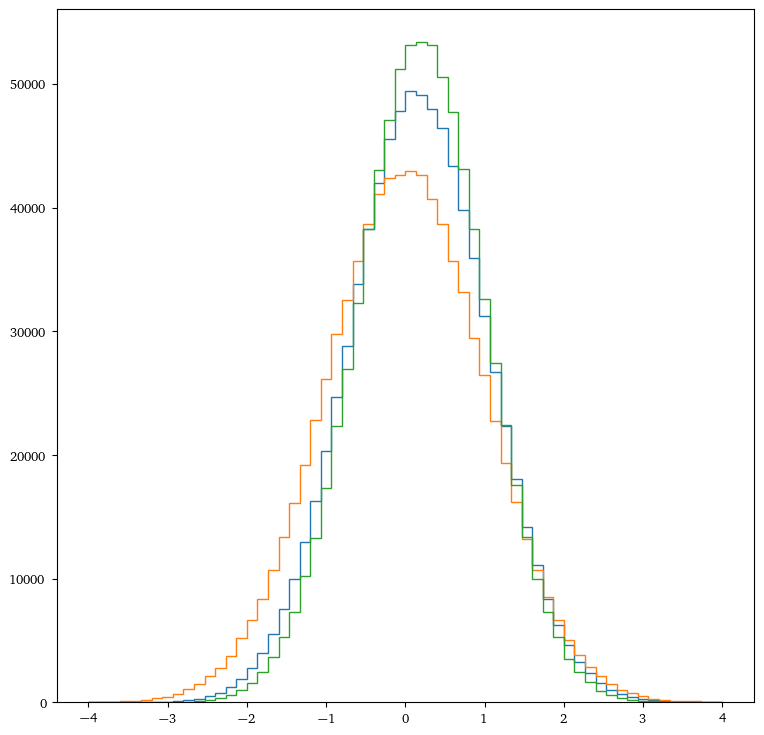

Starting with the 1.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.237004280090332 after time 11.5
    Finished epoch 6 with average loss 1.2366188764572144 after time 80.1
    Finished epoch 12 with average loss 1.2366375923156738 after time 148.4
    Finished epoch 18 with average loss 1.2365654706954956 after time 216.8
    Finished epoch 24 with average loss 1.2365802526474 after time 285.4
    Finished epoch 29 with average loss 1.236618161201477 after time 342.4
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5666528344154358 after time 8.0
    Finished epoch 6 with average loss 0.5649623870849609 after time 56.1
    Finished epoch 12 with average loss 0.5660393238067627 after time 104.3
    Finished epoch 18 with average loss 0.566035807132721 after time 152.5
    Finished epoch 24 with average loss 0.5662592649459839 after time 200.6
    Finished epoch 29 with average loss 0.565639078617096

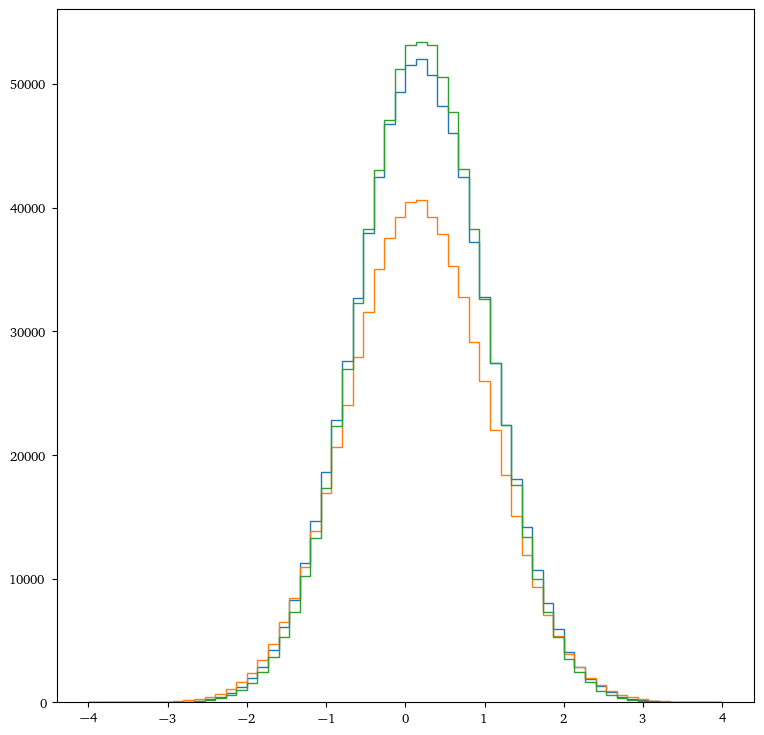

Starting with the 2.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.1395667791366577 after time 11.5
    Finished epoch 6 with average loss 1.1395052671432495 after time 80.0
    Finished epoch 12 with average loss 1.1394968032836914 after time 148.3
    Finished epoch 18 with average loss 1.139500379562378 after time 216.5
    Finished epoch 24 with average loss 1.1395081281661987 after time 284.7
    Finished epoch 29 with average loss 1.139499545097351 after time 341.6
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.553090512752533 after time 8.0
    Finished epoch 6 with average loss 0.5536600947380066 after time 55.9
    Finished epoch 12 with average loss 0.550959050655365 after time 104.0
    Finished epoch 18 with average loss 0.5509369373321533 after time 154.1
    Finished epoch 24 with average loss 0.5520221590995789 after time 202.2
    Finished epoch 29 with average loss 0.5522854328155

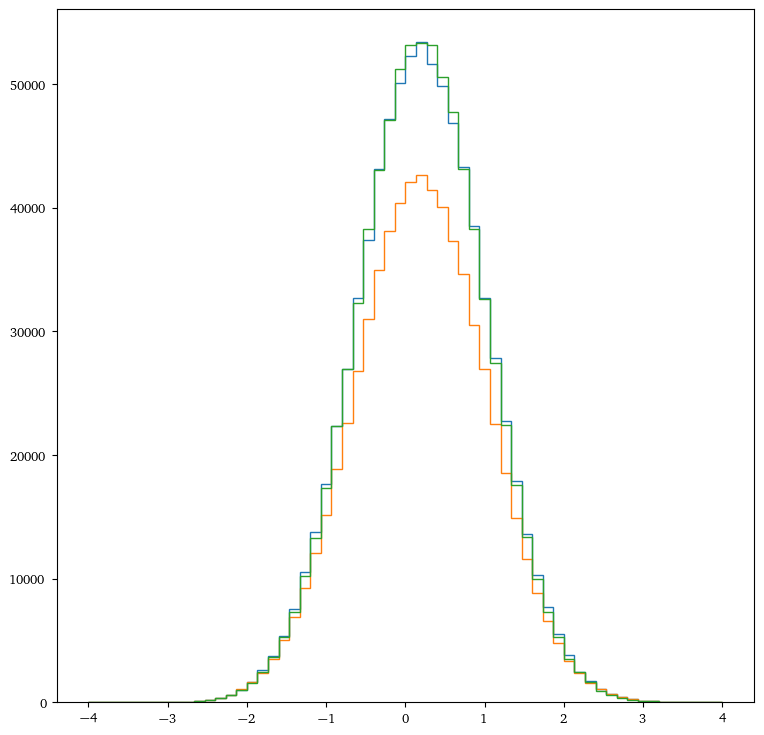

Starting with the 3.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.1356974840164185 after time 11.9
    Finished epoch 6 with average loss 1.1356755495071411 after time 80.4
    Finished epoch 12 with average loss 1.1356396675109863 after time 150.7
    Finished epoch 18 with average loss 1.1356300115585327 after time 219.1
    Finished epoch 24 with average loss 1.1356523036956787 after time 287.7
    Finished epoch 29 with average loss 1.1356600522994995 after time 345.0
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5453486442565918 after time 8.2
    Finished epoch 6 with average loss 0.546349287033081 after time 56.4
    Finished epoch 12 with average loss 0.5452001690864563 after time 104.6
    Finished epoch 18 with average loss 0.5438586473464966 after time 152.9
    Finished epoch 24 with average loss 0.5434696674346924 after time 201.1
    Finished epoch 29 with average loss 0.5444858670

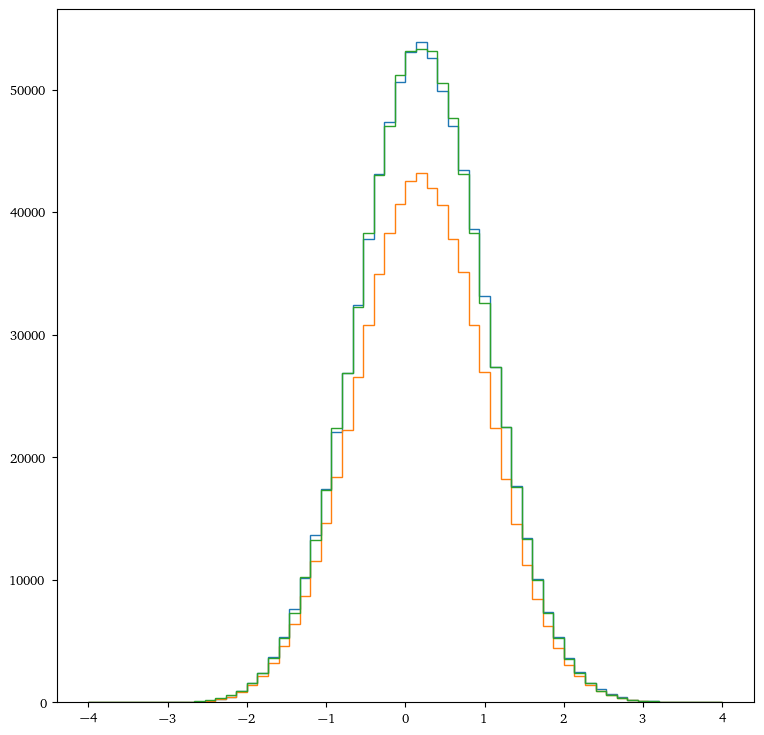

Starting with the 4.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.1320310831069946 after time 12.0
    Finished epoch 6 with average loss 1.132000207901001 after time 80.6
    Finished epoch 12 with average loss 1.1320366859436035 after time 149.2
    Finished epoch 18 with average loss 1.1320335865020752 after time 217.8
    Finished epoch 24 with average loss 1.1320412158966064 after time 286.4
    Finished epoch 29 with average loss 1.1320165395736694 after time 343.6
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5444324612617493 after time 8.0
    Finished epoch 6 with average loss 0.5456343293190002 after time 56.2
    Finished epoch 12 with average loss 0.5436762571334839 after time 104.4
    Finished epoch 18 with average loss 0.5437012314796448 after time 152.7
    Finished epoch 24 with average loss 0.54502272605896 after time 203.1
    Finished epoch 29 with average loss 0.544573068618

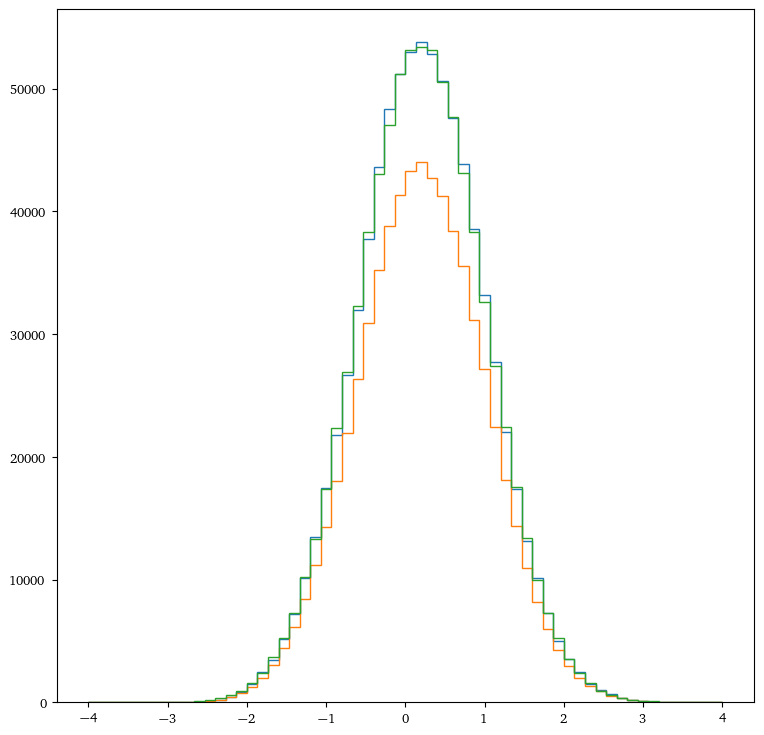

In [19]:
for i in range(iterative_unfolding_params["iterations"]):
    print(f"Starting with the {i}.iteration.")
    if i == 0:
        print("Initalize unfolder")
        unfolder = CFM(1, 1, iterative_unfolding_params["generator"])
        mc_gen = ToyModel.mc_gen[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_rec = ToyModel.mc_rec[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_weights = torch.ones_like(mc_rec[:, 0])
        data_weights = efficiency * background_weights
    if i > 0 :
        iterative_classifier = Classifier(1, iterative_unfolding_params["classifier"])
        iterative_classifier.train_classifier(data_unfold, mc_gen, data_weights, mc_weights)
        mc_weights *= iterative_classifier.evaluate(mc_gen)
    unfolder.train_unfolder(mc_gen, mc_rec, mc_weights)
    print("unfold data")
    data_unfold = unfolder.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
    fig, axes = plt.subplots()
    axes.hist(data_unfold[:,0], weights=data_weights, bins=60, histtype="step", range=[-4,4])
    axes.hist(mc_gen[:,0], weights=mc_weights, bins=60, histtype='step', range=[-4,4])
    axes.hist(ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool())&(ToyModel.data_gen_mask.bool())], bins=60, range=[-4,4], histtype="step")
    plt.show()

In [20]:
# fig, axes = plt.subplots()
#
# axes.hist(plot_gen, bins =60, histtype="step",range=[-4,4])
# axes.hist(data_unfold[:, 0], bins = 60, histtype="step", range=[-4,4], label="unfolded", weights = efficiency*background_weights)
# plt.show()

In [57]:
with PdfPages(f"Plots/prior_dependence.pdf") as out:
    plot_prior_unfold(out, ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())],ToyModel.mc_gen[:,0][(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())],
                                 data_unfold[:, 0],
                      unfolded_weights=efficiency*background_weights,
                                 range=[-3,4], name="x_1")

/var/folders/6c/yydcmmhj78584mfmjcg6jrgw0000gn/T/ipykernel_49922/2329372474.py:150: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/var/folders/6c/yydcmmhj78584mfmjcg6jrgw0000gn/T/ipykernel_49922/2329372474.py:151: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/var/folders/6c/yydcmmhj78584mfmjcg6jrgw0000gn/T/ipykernel_49922/2329372474.py:150: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


Train acceptance classifier

In [23]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [24]:
acceptance_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]

In [25]:
acceptance_classifier = Classifier(1, acceptance_classifier_params)

In [26]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

    Training with unbalanced training set with weight 8.979664474924324
Training classifier for 240 epochs with lr 0.0001
    Finished epoch 0 with average loss 3.90240740776062 after time 1.9
    Finished epoch 48 with average loss 3.2487246990203857 after time 64.6
    Finished epoch 96 with average loss 3.248654365539551 after time 126.6
    Finished epoch 144 with average loss 3.24867582321167 after time 189.4
    Finished epoch 192 with average loss 3.2486917972564697 after time 252.3
    Finished epoch 239 with average loss 3.248673439025879 after time 313.4


In [27]:
acceptance_weights = acceptance_classifier.evaluate(data_unfold, return_weights=False)

In [28]:
data_weights =efficiency*background_weights/ acceptance_weights

In [29]:
# fig,  axes = plt.subplots()
#
# axes.hist(data_unfold[:, 0], weights = data_weights, bins=60, histtype="step", range=[-3,3])
# axes.hist(ToyModel.data_gen[(ToyModel.data_gen_mask.bool())][:, 0], histtype="step", bins=60, range=[-3,3])
# axes.hist(ToyModel.mc_gen[(ToyModel.mc_gen_mask.bool())][:, 0], histtype="step", bins=60,  range=[-3,3])
# plt.show()

In [56]:
with PdfPages(f"Plots/acceptance_effects.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_gen[:,0][(ToyModel.data_gen_mask.bool())],
                                 data_unfold[:,0],
                                 data_unfold[:,0],
                                 reweighted_weights=efficiency*background_weights/acceptance_weights,
                                 fake_weights=efficiency*background_weights,
                                 range=[-3,4], labels=[r"$\text{gen}|_g$" , r"$\text{unfolded} / \delta$","unfolded"], name="x_1")

/var/folders/6c/yydcmmhj78584mfmjcg6jrgw0000gn/T/ipykernel_49922/2329372474.py:43: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/var/folders/6c/yydcmmhj78584mfmjcg6jrgw0000gn/T/ipykernel_49922/2329372474.py:44: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/var/folders/6c/yydcmmhj78584mfmjcg6jrgw0000gn/T/ipykernel_49922/2329372474.py:43: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


In [50]:
with PdfPages(f"Plots/final_unfolding.pdf") as out:
    plot_naive_unfold(out, ToyModel.data_gen[:, 0][
       (ToyModel.data_gen_mask.bool())],
                       ToyModel.data_rec[:, 0],
                      data_unfold[:, 0],
                        unfolded_weights=data_weights,
                      range=[-3, 4], name="x_1")

/var/folders/6c/yydcmmhj78584mfmjcg6jrgw0000gn/T/ipykernel_49922/2970127259.py:36: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/var/folders/6c/yydcmmhj78584mfmjcg6jrgw0000gn/T/ipykernel_49922/2970127259.py:37: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/var/folders/6c/yydcmmhj78584mfmjcg6jrgw0000gn/T/ipykernel_49922/2970127259.py:36: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
